In [3]:
transacciones = [
    {"pan", "leche", "huevos", "café", "azúcar", "mantequilla"},
    {"cereal", "leche", "plátano", "yogurt", "miel"},
    {"arroz", "frijoles", "aceite", "sal", "pollo"},
    {"pan", "queso", "jamón", "mantequilla", "jugo"},
    {"fideos", "salsa de tomate", "queso", "pan"},
    {"café", "leche", "galletas", "azúcar"},
    {"huevos", "tocino", "pan", "jugo", "mantequilla"},
    {"yogurt", "manzanas", "granola", "miel"},
    {"arroz", "pollo", "aceite", "sal"},
    {"cereal", "leche", "pan"},
    {"galletas", "chocolate", "refresco"},
    {"queso", "jamón", "pan", "mantequilla"},
    {"fideos", "salsa de tomate", "queso"},
    {"pan", "leche", "mantequilla", "café"},
    {"cereal", "leche", "jugo", "yogurt"},
    {"arroz", "frijoles", "pollo", "sal"},
    {"refresco", "papas fritas", "galletas"},
    {"jamón", "queso", "pan", "huevos"},
    {"huevos", "leche", "tocino", "pan"},
    {"yogurt", "granola", "miel"},
    {"jugo", "pan", "mantequilla", "queso"},
    {"cereal", "leche", "azúcar", "plátano"},
    {"galletas", "chocolate", "refresco"},
    {"queso", "jamón", "pan"},
    {"arroz", "pollo", "sal"},
    {"fideos", "salsa de tomate", "queso"},
    {"pan", "huevos", "café", "azúcar"},
    {"yogurt", "manzanas", "miel"},
    {"cereal", "leche", "plátano"},
    {"pan", "queso", "jamón", "tomate"},
    {"galletas", "chocolate", "refresco"},
    {"arroz", "frijoles", "pollo", "sal"},
    {"fideos", "salsa de tomate", "queso"},
    {"pan", "leche", "huevos", "café"},
    {"cereal", "leche", "yogurt"},
    {"huevos", "tocino", "pan", "jugo"},
    {"yogurt", "granola", "miel"},
    {"arroz", "pollo", "sal"},
    {"cereal", "leche", "jugo"},
    {"galletas", "chocolate", "refresco"},
    {"queso", "jamón", "pan"},
    {"fideos", "salsa de tomate", "queso"},
    {"pan", "leche", "mantequilla", "galletas"},
    {"cereal", "leche", "plátano", "miel"},
    {"arroz", "frijoles", "pollo"},
    {"galletas", "chocolate", "jugo"},
    {"queso", "jamón", "pan"},
    {"huevos", "tocino", "pan"},
    {"yogurt", "granola", "miel"},
    {"fideos", "salsa de tomate", "queso"},
    {"arroz", "pollo", "aceite", "sal"},
    {"jugo", "pan", "mantequilla"},
    {"cereal", "leche", "yogurt"},
    {"galletas", "chocolate", "refresco"},
    {"queso", "jamón", "pan"},
    {"fideos", "salsa de tomate", "queso"},
    {"pan", "huevos", "mantequilla"},
    {"arroz", "frijoles", "pollo"},
    {"cereal", "leche", "yogurt"},
    {"galletas", "chocolate", "refresco"},
    {"queso", "jamón", "pan"},
    {"fideos", "salsa de tomate", "queso"},
    {"café", "leche", "azúcar"},
    {"jugo", "galletas"},
    {"pan", "leche", "huevos"},
    {"arroz", "pollo"},
    {"cereal", "leche"},
    {"huevos", "pan"},
    {"galletas", "jugo"},
    {"jamón", "queso", "pan"},
    {"leche", "galletas"},
    {"yogurt", "manzanas"},
    {"pan", "queso"},
    {"huevos", "tocino"},
    {"arroz", "frijoles"},
    {"pan", "mantequilla", "miel"},
    {"refresco", "papas fritas"},
    {"cereal", "leche"},
    {"arroz", "pollo"},
    {"jugo", "manzanas"},
    {"jamón", "queso"},
    {"café", "leche"},
    {"manzanas", "jugo"},
    {"pan", "galletas"},
    {"huevos", "leche"},
    {"galletas", "chocolate"},
    {"pan", "mantequilla"},
    {"queso", "jamón"},
    {"cereal", "leche"},
]


Pregunta 6

In [4]:
from itertools import combinations
from collections import defaultdict

k = int(input("¿En cuántas transacciones desea que se muestren los conjuntos de productos? "))

def frequent_itemsets(transacciones, k):
    itemTrans = defaultdict(int)
    
    for t in transacciones:
        for r in range(2, 7):  
            for s in combinations(t, r):
                itemTrans[frozenset(s)] += 1
    
    agrupado = defaultdict(list)

    for itemset, cant in itemTrans.items():
        if cant >= k:  
            agrupado[len(itemset)].append(set(itemset))
    
    return agrupado

agrupados = frequent_itemsets(transacciones, k)
print(f"Subconjuntos frecuentes agrupados por tamaño de conjunto (al menos {k} apariciones):")
for tamaño, s in sorted(agrupados.items()):
    print(f"\nConjuntos de tamaño {tamaño}:")
    for sub in s:
        print(sub)

Subconjuntos frecuentes agrupados por tamaño de conjunto (al menos 3 apariciones):

Conjuntos de tamaño 2:
{'azúcar', 'leche'}
{'azúcar', 'café'}
{'pan', 'leche'}
{'mantequilla', 'leche'}
{'leche', 'café'}
{'leche', 'huevos'}
{'pan', 'mantequilla'}
{'pan', 'café'}
{'pan', 'huevos'}
{'mantequilla', 'huevos'}
{'café', 'huevos'}
{'plátano', 'leche'}
{'plátano', 'cereal'}
{'leche', 'cereal'}
{'leche', 'yogurt'}
{'miel', 'yogurt'}
{'cereal', 'yogurt'}
{'aceite', 'pollo'}
{'aceite', 'arroz'}
{'aceite', 'sal'}
{'pollo', 'frijoles'}
{'pollo', 'arroz'}
{'pollo', 'sal'}
{'arroz', 'frijoles'}
{'sal', 'frijoles'}
{'sal', 'arroz'}
{'jamón', 'queso'}
{'pan', 'jamón'}
{'pan', 'queso'}
{'mantequilla', 'queso'}
{'pan', 'jugo'}
{'mantequilla', 'jugo'}
{'salsa de tomate', 'fideos'}
{'salsa de tomate', 'queso'}
{'fideos', 'queso'}
{'galletas', 'leche'}
{'tocino', 'huevos'}
{'pan', 'tocino'}
{'miel', 'granola'}
{'manzanas', 'yogurt'}
{'yogurt', 'granola'}
{'galletas', 'chocolate'}
{'galletas', 'refresco'}


Pregunta 7

Edges in Co-occurrence Graph: [(1, 2, {'weight': 2}), (1, 3, {'weight': 2}), (1, 4, {'weight': 2}), (1, 5, {'weight': 2}), (1, 6, {'weight': 2}), (2, 3, {'weight': 2}), (2, 4, {'weight': 2}), (2, 5, {'weight': 2}), (2, 6, {'weight': 2}), (3, 4, {'weight': 2}), (3, 5, {'weight': 2}), (3, 6, {'weight': 2}), (4, 5, {'weight': 2}), (4, 6, {'weight': 2}), (5, 6, {'weight': 2})]


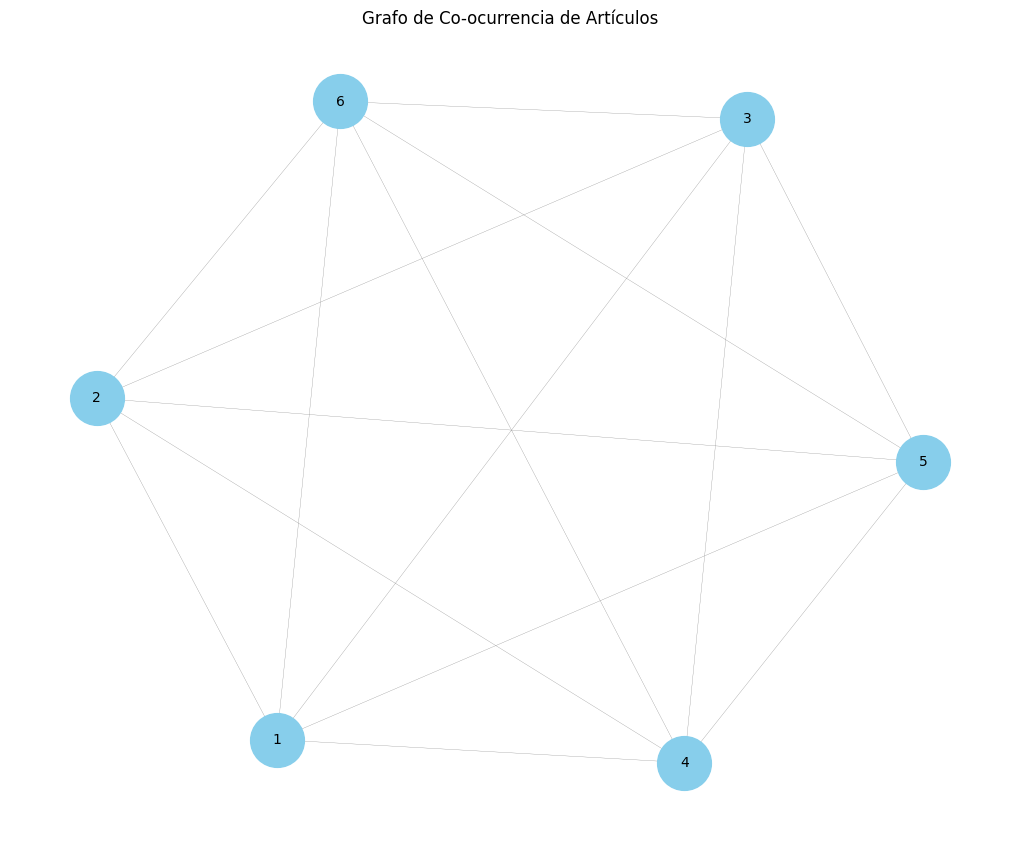

Pregunta 8

Comunidades de artículos que suelen comprarse juntos:
Comunidad 1: {1, 2, 3, 4, 5, 6}
